## Topic: Gated Recurrent Unit Models for Predicting Stock Prices 

### This notebook contains Python codes for four different variants of the Gated Recurrent Unit (GRU) models namely: the standard GRU, GRU Variant 1, GRU Variant 2 and GRU Variant 3. The four models are used to predict the Netherlands stock market. The results of the models are compared.

In [42]:
# Import of some useful libraries
import tensorflow as tf
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import sklearn
from sklearn.utils import check_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [43]:
#Functions for Calculating Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_pred))*100

## Building the GRU models

In [44]:
# initialisation of parameters (weights and biases)
def parameters_initialiser(input_dimensions, hidden_size, mean, std, dtype=tf.float64):
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(input_dimensions[1], hidden_size,), mean=mean, stddev=std), name='Wr')
        Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(input_dimensions[1],hidden_size,), mean=mean, stddev=std), name='Wz')
        Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(input_dimensions[1], hidden_size,), mean=mean, stddev=std), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(hidden_size, hidden_size,), mean=mean, stddev=std), name='Ur')
        Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(hidden_size, hidden_size,), mean=mean, stddev=std), name='Uz')
        Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(hidden_size, hidden_size,), mean=mean, stddev=std), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(hidden_size,), mean=mean, stddev=std), name='br')
        bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(hidden_size,), mean=mean, stddev=std), name='bz')
        bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(hidden_size,), mean=mean, stddev=std), name='bh')
        return Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh
    
class GRU:
    "class for GRU models"
    def __init__(self, input_dimensions, hidden_size, batch_size, variant, optimizer, lookback, delay):
        """Implementation of a Gated Recurrent Unit (GRU).
    
        Arguments
        ---------
        input_dimensions: tuple. The size of the input vectors (x_t).
        hidden_size: int. The size of the hidden layer vectors (h_t).
        batch_size:
        variant: int.
        optimizer:
        lookback:
        delay:
        """
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.variant = variant
        self.optimizer=optimizer
        self.lookback=lookback
        self.delay=delay
    
    def initiliaser(self, Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh, dtype=tf.float64):
        self.Wr, self.Wz, self.Wh, self.Ur, self.Uz, self.Uh, self.br, self.bz, self.bh=Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None,None, self.input_dimensions[1]), name='input')
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [0, 1, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(self.input_dimensions[1],self.hidden_size,), name='h_0'))
        # Perform the scan operator
        variants=[self.forward_pass, self.forward_pass_variant1, self.forward_pass_variant2, self.forward_pass_variant3]
        self.h_t_transposed = tf.scan(variants[self.variant], self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [0, 1,2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass for the standard GRU.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        return h_t
    
    def forward_pass_variant1(self, h_tm1, x_t):
        """Perform a forward pass for GRU variant 1.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t
    def forward_pass_variant2(self, h_tm1, x_t):
        """Perform a forward pass for GRU variant 2.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(h_tm1, self.Uz))
        r_t = tf.sigmoid(tf.matmul(h_tm1, self.Ur))
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t
    def forward_pass_variant3(self, h_tm1, x_t):
        """Perform a forward pass for GRU variant 3.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(self.bz)
        r_t = tf.sigmoid(self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t

    def get_next_batch(self):
        """
        this function sequences data into batch
        """
        start = self.index_in_epoch
        self.index_in_epoch += self.batch_size
        
        if self.index_in_epoch > self.X_train.shape[0]:
            np.random.shuffle(self.perm_array) # shuffle permutation array
            start = 0 # start next epoch
            self.index_in_epoch = self.batch_size
            
        end = self.index_in_epoch
        return self.X_train[self.perm_array[start:end]], self.y_train[self.perm_array[start:end]]
        
    def train(self,X_train, y_train, X_val, y_val, n_epochs, mean=0, std=0.01):
        """training of the model is implemented here"""
        
        self.X_train, self.y_train, self.X_val, self.y_val=X_train, y_train, X_val, y_val
        self.index_in_epoch = 0;
        self.perm_array  = np.arange(X_train.shape[0])
        np.random.shuffle(self.perm_array)
        
        self.train_set_size = self.X_train.shape[0]

        # Initialize a session
        self.session = tf.Session()

        # Add an additional layer on top of each of the hidden state outputs
        W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(self.hidden_size, self.delay), mean=mean, stddev=std))
        b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(self.delay,), mean=mean, stddev=std))
        self.output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, self.h_t)
        
        # Create a placeholder for the expected output
        expected_output = tf.placeholder(dtype=tf.float64, shape=(None, self.delay), name='expected_output')
        self.output= tf.reduce_mean(self.output, axis=1)
        
        # Just use quadratic loss
        self.loss = tf.reduce_mean(tf.square(self.output - expected_output))

        # Use the Adam optimizer for training
        self.train_step = self.optimizer.minimize(self.loss)
        

        # Initialize all the variables
        init_variables = tf.global_variables_initializer()
        self.session.run(init_variables)

        # Initialize the losses
        train_losses = []
        validation_losses = []
        
        for iteration in range(int(n_epochs*self.train_set_size/self.batch_size)):
            x_batch, y_batch = self.get_next_batch() # fetch the next training batch 
            self.session.run(self.train_step, feed_dict={self.input_layer: x_batch, expected_output: y_batch}) 
            if iteration % int(5*self.train_set_size/self.batch_size) == 0:
                mse_train = self.loss.eval(session=self.session, feed_dict={self.input_layer: X_train, expected_output: y_train}) 
                mse_valid = self.loss.eval(session=self.session, feed_dict={self.input_layer: X_val, expected_output: y_val}) 
                train_losses.append(mse_train)
                validation_losses.append(mse_valid)
                print('%.2f epochs: MSE train/valid = %.6f/%.6f (variant = %d)'%(
                    iteration*self.batch_size/self.train_set_size, mse_train, mse_valid, self.variant))

        return train_losses, validation_losses
    def predict(self,X_test):
        # Make a prediction by using the model
        y_predicted = self.session.run(self.output, feed_dict={self.input_layer: X_test})
        
        return y_predicted

## We load our data
 

`Several markets are used as variables for predicting the Netherlands stock market. The various stock markets used are described in the table below.`


| Sticker Symbol | Name | Stock Market | Country |
| --- | --- | --- | --- |
| AMSTEOE| AEX Index | Euronext Amstadam | Netherlands |
|  DAXINDX |DAX Index| Frankfurt Stock Exchange|Germany |
|FREAC40|CAC40 Index| Euronext Paris|France|
|FTSE100|Financial Time Stock Exchange Index| London Stock Exchange|England (UK)|
|HNGKNG|Hang Sang Index|Hong Kong Stock Exchange|China|
|JAPDOWA|Nikkei 225 Stock Average|Tokyo Stock Exchange|Japan|
|NASCOMP|NASDAQ Composite|NASDAQ Stock Exchange  |USA|
|GRANGENL| ATHEX Composite|Athens Stock Exchange  |Greece|
    

`We present a sample of the stock prices taken from each market below.`

In [45]:
dataset = pd.read_csv('st_indices.csv', header=0 )

In [46]:
dataset.head()

,Unnamed: 0,AMSTEOE,DAXINDX,FRCAC40,FTSE100,HNGKNGI,PDOWA,GALLS,COMP
0,0,261.36,1411.28,1482.89,2371.0,3225.97,23755.89,387.17,307.52
1,1,262.02,1419.76,1490.42,2382.0,3207.21,24102.98,391.44,308.37
2,2,263.32,1431.03,1490.42,2386.6,3216.11,24118.01,393.99,307.63
3,3,264.98,1440.47,1490.42,2403.0,3253.42,23931.52,390.23,310.68
4,4,264.50,1462.16,1490.42,2419.2,3262.30,23969.76,395.71,310.42


In [47]:
dataset.shape

(2734, 9)

In [48]:
price_data = dataset.values[:, 1:]

## Normalizing our data

`Our data involves large values which will be difficult to work with. To make it easier and to save computational cost, we need to normalize it. The normalization process reduces the values into a required range of smaller values that will be easy to work with. Here, we normalize the values to the range 0-1.`

To normalize our data, we use the formula :
\begin{align}
x'= \frac{x-x_{min}}{x_{max}-x_{min} }
 \end{align}
 
 Where $x'$ is the new dataset obtained in the range $[0,1]$, $x$ is the old value, while $x_{min}$ and $x_{max}$ are the minimum and maximum values of the dataset respectively.  

In [49]:
def normaliser(data, frange=(0, 1)): # nomalizing the data
    # normalize features - 
    scaler = MinMaxScaler(feature_range=frange)
    scaled = scaler.fit_transform(data)
    return scaled, scaler

In [50]:
price_predictors, scaler_predictor = normaliser(price_data[:, :], frange=(0, 1))
price_predictors.shape

(2734, 8)

In [51]:
price_target, scaler_target = normaliser(price_data[:, 0].reshape(-1, 1), frange=(0, 1))
price_target.shape

(2734, 1)

In [52]:
price_target, scaler_target = normaliser(price_data[:, 0].reshape(-1, 1), frange=(0, 1))
price_target.shape

(2734, 1)

In [53]:
price_data = np.append(price_target, price_predictors[:, :-1], axis=1)
price_data.shape

(2734, 8)

### Configuration

`The parameters of our models are given below`

In [54]:
# Configuration
lookback=1 # using the previous day value
n_epochs=100 #vnumber of iterations
delay=1 # number of days we are predicting
batch_size = 25 # the batch size at each step
n_features=8
input_dimensions=(lookback, n_features)
hidden_size=64
optimizer=tf.train.AdamOptimizer(learning_rate=0.0015)
#optimizer = tf.train.FtrlOptimizer(0.1)

## Setting up our data

In [55]:
def gru_data_setup(data, lookback, delay, min_index, max_index):
    '''
    data:     Shape (n_samples,n_features). First column is the time series, other columns are the features
    lookback: Number of time steps in the RNN >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x,y) of numpy arrays where x is in shape (n_samples,n_timesteps,n_features) and
             y is in shape (n_samples,delay). y is an array of target arrays each of size delay. To forecast
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    '''
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
                 
    samp=[];targ=[]
    for j in range(n_samples): 
        indices1 = range(j, j+lookback)
        indices2 = range(j+lookback, j+lookback+delay)
        samples[j] = data[indices1]
        targets[j,:] = data[indices2][0:delay][:,0]
        #print(samples,targets)
    samp.append(samples);targ.append(targets)

    return np.array(samp)[0],np.array(targ)[0]

X_data, y_data=gru_data_setup(price_data, lookback, delay, min_index=0, max_index=2733)
X_data.shape, y_data.shape

((2733, 1, 8), (2733, 1))

## Splitting the data

`We split the data into three different parts : Training, Validation and Test sets.`
`The training set is used to train our models. The validation set is used to tune our parameters whereas the test set is used to make predictions.`

In [56]:
n=len(price_data)
n_train = int(0.8*n) # 80% of the whole dataset is used for tarining
n_val=int(0.2*n_train) # 20% of the training is used for validation
n_train=n_train-n_val # the rest of the 20% of the dataset is the test set
n_test = n-n_train-n_val

X_train, y_train=X_data[:n_train, :, :], y_data[:n_train, :]
X_val, y_val=X_data[n_train:n_train+n_val, :, :], y_data[n_train:n_train+n_val, :]
X_test, y_test=X_data[n_train+n_val:, :, :], y_data[n_train+n_val:, :]

In [57]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1750, 1, 8), (1750, 1), (437, 1, 8), (437, 1), (546, 1, 8), (546, 1))

### GRU models

In [58]:
variant=0
gru_standard=GRU(input_dimensions, hidden_size, batch_size, variant, optimizer, lookback, delay)
variant=1
gru_variant_1=GRU(input_dimensions, hidden_size, batch_size, variant, optimizer, lookback, delay)
variant=2
gru_variant_2=GRU(input_dimensions, hidden_size, batch_size, variant, optimizer, lookback, delay)
variant=3
gru_variant_3=GRU(input_dimensions, hidden_size, batch_size, variant, optimizer, lookback, delay)

In [59]:
# initial weights and biases for all the models
mean, std=0, 0.01
Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh=parameters_initialiser(input_dimensions, hidden_size, mean,std)

In [60]:
gru_standard.initiliaser(Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh)
gru_variant_1.initiliaser(Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh)
gru_variant_2.initiliaser(Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh)
gru_variant_3.initiliaser(Wr, Wz, Wh, Ur, Uz, Uh, br, bz, bh)

In [61]:
# models in a list
grus= [gru_standard, gru_variant_1, gru_variant_2, gru_variant_3]

## Printing the training and validation losses

In [62]:
losses=[]
predicts_train=[]
predicts_val=[]
predicts_test=[]
for model in grus:
    train_losses, val_losses=model.train(X_train, y_train, X_val, y_val, n_epochs=100, mean=mean, std=std)
    losses.append([train_losses, val_losses])
    
    predicts_train.append(model.predict(X_train))
    predicts_val.append(model.predict(X_val))
    predicts_test.append(model.predict(X_test))

0.00 epochs: MSE train/valid = 0.029111/0.105051 (variant = 0)
5.00 epochs: MSE train/valid = 0.000178/0.002917 (variant = 0)
10.00 epochs: MSE train/valid = 0.000063/0.001118 (variant = 0)
15.00 epochs: MSE train/valid = 0.000026/0.000212 (variant = 0)
20.00 epochs: MSE train/valid = 0.000015/0.000037 (variant = 0)
25.00 epochs: MSE train/valid = 0.000014/0.000024 (variant = 0)
30.00 epochs: MSE train/valid = 0.000013/0.000014 (variant = 0)
35.00 epochs: MSE train/valid = 0.000016/0.000023 (variant = 0)
40.00 epochs: MSE train/valid = 0.000013/0.000012 (variant = 0)
45.00 epochs: MSE train/valid = 0.000013/0.000012 (variant = 0)
50.00 epochs: MSE train/valid = 0.000020/0.000020 (variant = 0)
55.00 epochs: MSE train/valid = 0.000014/0.000013 (variant = 0)
60.00 epochs: MSE train/valid = 0.000013/0.000027 (variant = 0)
65.00 epochs: MSE train/valid = 0.000012/0.000013 (variant = 0)
70.00 epochs: MSE train/valid = 0.000014/0.000019 (variant = 0)
75.00 epochs: MSE train/valid = 0.000013/0

## Plotting the tarining and validation loss results

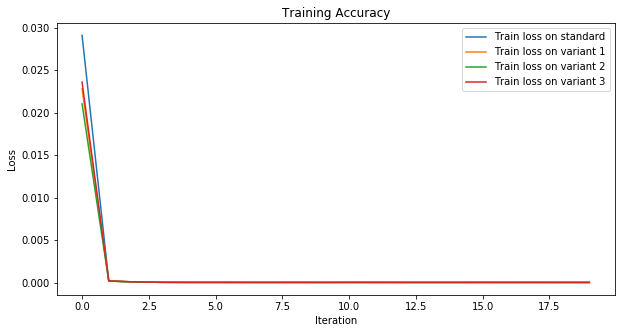

In [63]:
plt.figure(figsize=(10,5))
types=["standard", "variant 1", "variant 2", "variant 3"]
for i in range(len(grus)):
    plt.plot(losses[i][0], label='Train loss on '+types[i])
plt.legend(loc=0)
plt.title('Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Training-loss.eps', format = 'eps', dpi = 1000)
plt.show()

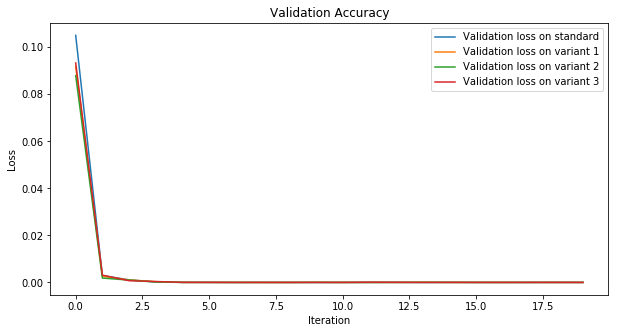

In [64]:
# Display losses
plt.figure(figsize=(10,5))
types=["standard", "variant 1", "variant 2", "variant 3"]
for i in range(len(grus)):
    plt.plot(losses[i][1], label='Validation loss on '+types[i])
plt.legend(loc=0)
plt.title('Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Validation-loss.eps', format = 'eps', dpi = 1000)
#print('MAE is: ', mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ))
plt.show()

`In order to the original values back, we reverse the normalized values. This is done below.`

In [65]:
actual_train=scaler_target.inverse_transform(y_train)# reversing the training set
actual_val=scaler_target.inverse_transform(y_val) # reversing the validation set
actual_test=scaler_target.inverse_transform(y_test) # reversing the test set

## Plotting the test predictions for all the models

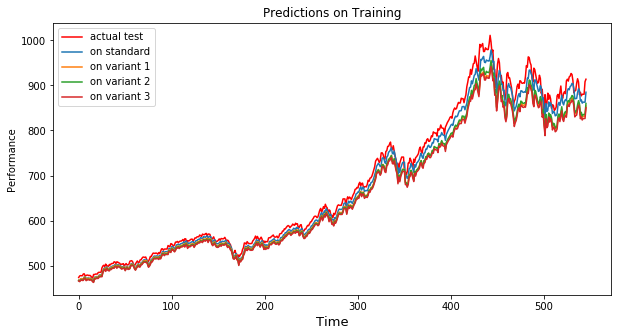

In [66]:
plt.figure(figsize=(10,5))
plt.clf()
types=["standard", "variant 1", "variant 2", "variant 3"]
plt.plot( actual_test[:, -1], label='actual test', color = 'r')

#plt.plot(standard, label='standard GRU', color = 'b')
#plt.plot(Variant1, label='Variant 1', color = 'g')
#plt.plot(Variant2, label='Variant 2', color = 'orange')
#plt.plot(Variant3, label='Variant 3', color ='purple')


errors_test = {}
for i in range(len(grus)):
    predicts_test_=np.array(predicts_test[i])
    predicts_te = scaler_target.inverse_transform(predicts_test_)
    plt.plot(predicts_te[:, -1], label='on '+types[i])
plt.legend(loc=0)
plt.title('Predictions on Training')
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Performance')
plt.savefig('Combined.eps', format = 'eps', dpi = 1000)
plt.show()

## Plotting the training, validation and test targets of all the models.

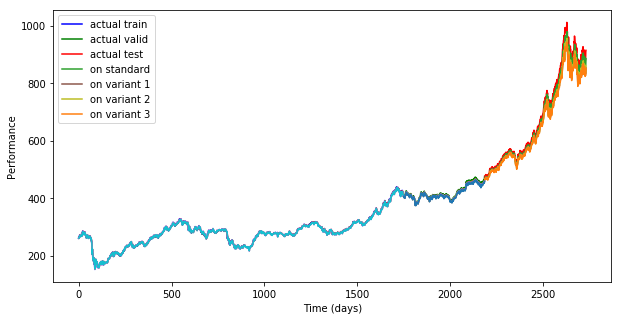

In [67]:
plt.figure(figsize=(10,5))
plt.clf()
types=["standard", "variant 1", "variant 2", "variant 3"]
n_train_range =range(len(actual_train))
n_val_range =range(len(actual_train), len(actual_train)+len(actual_val))
n_test_range =range(len(actual_train)+len(actual_val), len(actual_train)+len(actual_val)+len(actual_test))

plt.plot(n_train_range, actual_train[:, -1], label='actual train', color = 'b')
plt.plot(n_val_range, actual_val[:, -1], label='actual valid', color = 'g')
plt.plot(n_test_range, actual_test[:, -1], label='actual test', color = 'r')

errors_test = {}
for i in range(len(grus)):
    predicts_train_=np.array(predicts_train[i])
    predicts_tr = scaler_target.inverse_transform(predicts_train_)
    plt.plot(n_train_range, predicts_tr[:, -1])
    
    predicts_val_=np.array(predicts_val[i])
    predicts_v = scaler_target.inverse_transform(predicts_val_)
    plt.plot(n_val_range, predicts_v[:, -1])
    
    predicts_test_=np.array(predicts_test[i])
    predicts_te = scaler_target.inverse_transform(predicts_test_)
    plt.plot(n_test_range, predicts_te[:, -1], label='on '+types[i])
    
    errors_test[types[i]]=np.mean(np.power(actual_test[:, -1]-predicts_te[:, -1], 2))

plt.legend(loc=0)
#plt.title('Predictions on Training')
plt.xlabel('Time (days)')
plt.ylabel('Performance')
plt.savefig('Train_test_validation_pediction.eps', format = 'eps', dpi = 1000)
plt.show()

### Plotting actual  prices (Test)   and standard GRU prediction

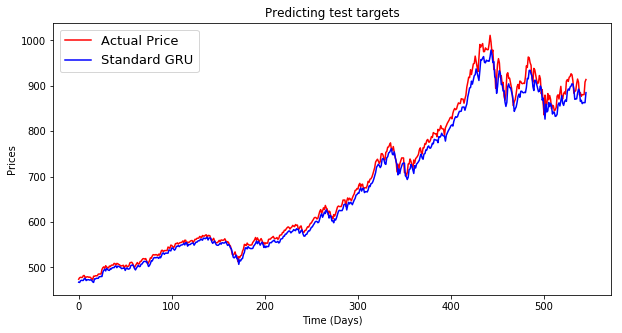

MAE is:  12.892324683698508
MSE is:  263.5384055867602
RMSE is:  16.233866008648715
MAPE is:  1.8123599537576818


In [77]:
plt.figure(figsize=(10,5))
plt.clf()
n_train_range =range(len(actual_train))
n_val_range =range(len(actual_train), len(actual_train)+len(actual_val))
n_test_range =range(len(actual_train)+len(actual_val), len(actual_train)+len(actual_val)+len(actual_test))
plt.plot(actual_test[:, -1], label='Actual Price', color = 'r')
predicts_test_=np.array(predicts_test[0])
predicts_te = scaler_target.inverse_transform(predicts_test_)
Standard = predicts_te[:, -1]
plt.plot(Standard, label='Standard GRU', color ='b')
plt.legend(loc=0, fontsize = 13 )
plt.title('Predicting test targets')
plt.xlabel('Time (Days)')
plt.ylabel('Prices')
plt.savefig('Standard_GRU.eps', format = 'eps', dpi = 1000)
plt.show()
print('MAE is: ', mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ))
print('MSE is: ', mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ))
print('RMSE is: ', np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ))
print('MAPE is: ', mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1]))
Errors1 = [mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ),mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ),np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ), mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1])  ]

In [69]:
Standard[0:4]

array([467.3095654 , 466.77913586, 470.51898997, 471.51861002])

  ### Plotting actual  prices (Test)   and GRU Variant 1  prediction

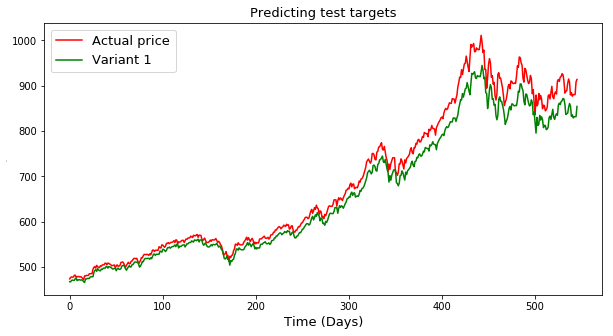

MAE is:  24.93629338605979
MSE is:  989.4125947261533
RMSE is:  31.454929577510633
MAPE is:  3.4305635552265583


In [80]:
plt.figure(figsize=(10,5))
plt.clf()

n_train_range =range(len(actual_train))
n_val_range =range(len(actual_train), len(actual_train)+len(actual_val))
n_test_range =range(len(actual_train)+len(actual_val), len(actual_train)+len(actual_val)+len(actual_test))
plt.plot(actual_test[:, -1], label='Actual price', color = 'r')
predicts_test_=np.array(predicts_test[1])
predicts_te = scaler_target.inverse_transform(predicts_test_)
Variant1 = predicts_te[:, -1]
#plots
plt.plot(Variant1, label='Variant 1', color ='g')
plt.legend(loc=0, fontsize = 13 )
plt.title('Predicting test targets', fontsize = 13)
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Prices', fontsize = 1)
plt.savefig('GRU_variant1.eps', format = 'eps', dpi = 1000)
plt.show()
print('MAE is: ', mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ))
print('MSE is: ', mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ))
print('RMSE is: ', np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ))
print('MAPE is: ', mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1]))
Errors2 = [mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ),mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ),np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ), mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1])  ]

In [71]:
Variant1[0:4]

array([467.71796643, 467.42604535, 470.54257871, 471.21160174])

### Plotting actual  prices (Test)   and GRU Variant 2  prediction

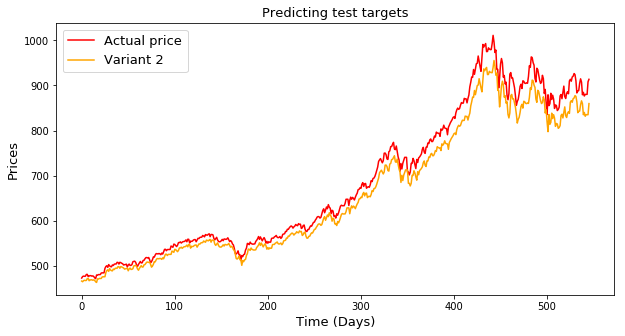

MAE is:  24.83245661699234
MSE is:  895.4440873598271
RMSE is:  29.923971784504594
MAPE is:  3.495635862019571


In [81]:
plt.figure(figsize=(10,5))
plt.clf()

n_train_range =range(len(actual_train))
n_val_range =range(len(actual_train), len(actual_train)+len(actual_val))
n_test_range =range(len(actual_train)+len(actual_val), len(actual_train)+len(actual_val)+len(actual_test))
plt.plot(actual_test[:, -1], label='Actual price', color = 'r')
predicts_test_=np.array(predicts_test[2])
predicts_te = scaler_target.inverse_transform(predicts_test_)
Variant2 = predicts_te[:, -1]
#plots
plt.plot(Variant2, label='Variant 2', color = 'orange')
plt.legend(loc=0, fontsize = 13 )
plt.title('Predicting test targets', fontsize = 13)
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Prices', fontsize = 13)
plt.savefig('GRU_variant2.eps', format = 'eps', dpi = 1000)
plt.show()
print('MAE is: ', mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ))
print('MSE is: ', mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ))
print('RMSE is: ', np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ))
print('MAPE is: ', mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1]))
Errors3 = [mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ),mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ),np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ), mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1])  ]

### Plotting actual  prices (Test)   and GRU Variant 3  prediction

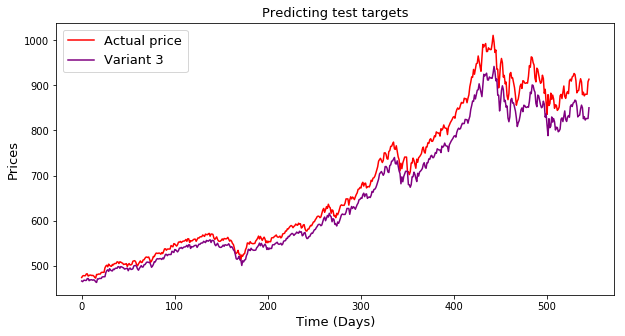

MAE is:  28.95357490095591
MSE is:  1224.3003642263525
RMSE is:  34.99000377574076
MAPE is:  4.074585536970371


In [82]:
plt.figure(figsize=(10,5))
plt.plot(actual_test[:, -1], label='Actual price', color = 'r')
predicts_test_=np.array(predicts_test[3])
predicts_te = scaler_target.inverse_transform(predicts_test_)
Variant3 = predicts_te[:, -1]
#plots
plt.plot(Variant3, label='Variant 3', color ='purple')
plt.legend(loc=0, fontsize = 13 )
plt.title('Predicting test targets', fontsize = 13)
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Prices', fontsize = 13)
plt.savefig('GRU_Variant3.eps', format = 'eps', dpi = 1000)
plt.show()
print('MAE is: ', mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ))
print('MSE is: ', mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ))
print('RMSE is: ', np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ))
print('MAPE is: ', mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1]))
Errors4 = [mean_absolute_error(actual_test[:, -1],predicts_te[:, -1] ),mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ),np.sqrt(mean_squared_error(actual_test[:, -1],predicts_te[:, -1] ) ), mean_absolute_percentage_error(actual_test[:, -1],predicts_te[:, -1])  ]

## Printing a sample of the  predictions made by each model.

In [74]:
DF = pd.DataFrame({'Standard':Standard,'GRU_Variant 1':Variant1, 'GRU_Variant 2':Variant2, 'GRU_Variant 3':Variant3, 'Actual Prices':actual_test[:, -1] })
DF.head()

,Actual Prices,GRU_Variant 1,GRU_Variant 2,GRU_Variant 3,Standard
0,473.85,467.717966,467.113307,466.065904,467.309565
1,477.22,467.426045,465.715495,464.677302,466.779136
2,478.11,470.542579,468.187578,467.345527,470.518990
3,477.77,471.211602,468.848964,467.899416,471.518610
4,477.88,470.587667,468.336863,467.311212,471.097630


In [75]:
DF.to_csv('Predicted Prices', sep = ',', header = True)

### Table of Errors

`The table below measures the performance of each model. Using the four metrics, the Standard GRU has the best performace since it has the least error in all the cases.` 

| Model | MAE | MSE | RMSE |MAPE |
| --- | --- | --- | --- |---|
| Standard GRU (Variant $0$)|12.8923|263.5384  |16.2339 |1.8124 |   
|  Variant 1|24.9363 |989.4126  |31.4549  |3.4306 |
|Variant 2    |24.8325  |895.4441  |29.9240  |3.4956|
|Variant 3|28.9536    |1224.3004  |34.9900  |4.0746|
